In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading & Preprocessing

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data
df_train = pd.read_csv(r"/kaggle/input/amazon-reviews/train.csv",header = None)
df_test = pd.read_csv(r"/kaggle/input/amazon-reviews/test.csv", header = None)

In [3]:
df_train.shape,df_test.shape

((3600000, 3), (400000, 3))

In [4]:
df_train.head()

0                                                  1  \
0  2                     Stuning even for the non-gamer   
1  2              The best soundtrack ever to anything.   
2  2                                           Amazing!   
3  2                               Excellent Soundtrack   
4  2  Remember, Pull Your Jaw Off The Floor After He...   

                                                   2  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...

0th column: polarity<br>
1 -> Negative & 2 -> Positive<br>
1st Column : Title<br>
2nd Column : Review

In [5]:
# Checking for missing values
df_train.isnull().sum()

0      0
1    207
2      0
dtype: int64

In [6]:
# Checking for data imbalance
df_train[0].value_counts()

0
2    1800000
1    1800000
Name: count, dtype: int64

In [7]:
df_test.isnull().sum()

0     0
1    24
2     0
dtype: int64

In [8]:
# Addressing the missing values
df_train.fillna("",inplace = True)
df_test.fillna("",inplace=True)

# Feature engineering
df_train['reviews'] = df_train[1] +" " + df_train[2]
df_test['reviews'] = df_test[1] + " " + df_test[2]

# Target as 0 and 1
df_train['labels'] = df_train[0]-1
df_test['labels'] = df_test[0] - 1

# Dropping unnecessary clomuns
df_train.drop([0,1,2],axis = 1, inplace = True)
df_test.drop([0,1,2],axis = 1, inplace = True)

# Sampling the train and test data to reduce training time
df_train = df_train.sample(100000)
df_test = df_test.sample(40000)

In [9]:
def sentiment(row):
    if (row['labels']):
        row['sentiment'] = 'positive'
    else:
        row['sentiment'] = 'negative'
    return row

In [10]:
df_train = df_train.apply(sentiment, axis = 1)
df_test = df_test.apply(sentiment, axis = 1)

# Data Cleaning

In [11]:
import re
import string

In [12]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [13]:
df_train['reviews']=df_train['reviews'].apply(lambda x:review_cleaning(x))
df_test['reviews']=df_test['reviews'].apply(lambda x:review_cleaning(x))

In [14]:
# Removing stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [15]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

nltk stop words contains words like not,hasn't,would'nt which actually conveys a negative sentiment. If we remove that it will end up contradicting the target variable(sentiment). So I have to curate the stop words which doesn't have any negative sentiment or any negative alternatives.

In [16]:
original_stop_words = set(stopwords.words('english'))

# List of words to exclude (negation words and words with negative sentiment)
negation_words = {
    'no', 'nor', 'not', "don't", "shouldn't", 'ain', 'aren', "aren't", 
    'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', 
    "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', 
    "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 
    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', 
    "won't", 'wouldn', "wouldn't"
}

curated_stop_words = original_stop_words - negation_words

# Convert the set back to a sorted list for readability
curated_stop_words = sorted(list(curated_stop_words))

print(curated_stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'd', 'did', 'do', 'does', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'more', 'most', 'my', 'myself', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'she', "she's", 'should', "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'we', 'were', 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'w

In [17]:
df_train['reviews'] = df_train['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (curated_stop_words)]))
df_test['reviews'] = df_test['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (curated_stop_words)]))

In [18]:
import spacy
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    """
    Lemmatizing the words instead of stemming to prevent loss of semantic meaning.
    """
    doc = nlp(text)
    filtered_tokens = []
    for token in doc:
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)

In [19]:
data = {'reviews': list(negation_words)}
df_sample = pd.DataFrame(data)

# Apply preprocessing function
df_sample['preprocessed_reviews'] = df_sample['reviews'].apply(preprocess)

print(df_sample)

      reviews preprocessed_reviews
0       don't               do not
1    wouldn't            would not
2      wouldn               wouldn
3    couldn't            could not
4      didn't               do not
5      aren't               be not
6        hadn                 hadn
7        shan                 shan
8        wasn                 wasn
9          no                   no
10        won                  win
11    doesn't               do not
12        not                  not
13     wasn't               be not
14     mightn               mightn
15      needn                needn
16    weren't               be not
17      doesn                doesn
18      won't             will not
19   mightn't            might not
20       hasn                 hasn
21     hadn't             have not
22      haven                haven
23        ain                  ain
24    mustn't             must not
25     hasn't             have not
26        nor                  nor
27      mustn       

As we can see lemmatization doesnt affect negative stop words and withholds the semantic meaning of words. So we will use lemmatization to further clean our reviews

In [20]:
from tqdm import tqdm
tqdm.pandas()
df_train['reviews'] = df_train['reviews'].progress_apply(preprocess)

100%|██████████| 100000/100000 [25:29<00:00, 65.40it/s]


In [21]:
# Saving the cleaned training data
df_train.to_csv('amazon_train.csv')

In [22]:
tqdm.pandas()
df_test['reviews'] = df_test['reviews'].progress_apply(preprocess)

100%|██████████| 40000/40000 [09:57<00:00, 66.99it/s]


In [23]:
#Saving the cleaned test data
df_test.to_csv('amazon_test.csv')

In [17]:
train_df = pd.read_csv(r"/kaggle/input/amazon-sentiment/amazon_train.csv")
train_df.drop('Unnamed: 0',axis = 1, inplace= True)
train_df.head()

reviews  labels sentiment
0  ho hum series grab hook good right start say w...       0  negative
1  case still open cornwell seem not read large b...       0  negative
2  political nonsense I m police officer local ag...       0  negative
3  no subtitle good transfer set consist disk one...       1  positive
4  helpful book understand ritual abuse panic exc...       0  negative

In [18]:
# Encountered a missing value
train_df.loc[68074]

reviews           NaN
labels              1
sentiment    positive
Name: 68074, dtype: object

In [19]:
train_df = train_df.drop(68074)

In [20]:
test_df = pd.read_csv(r"/kaggle/input/amazon-sentiment/amazon_test.csv")
test_df.drop('Unnamed: 0',axis = 1, inplace= True)
test_df.head()

reviews  labels sentiment
0  roomy cake caddy roomy tall cake wide cake cla...       1  positive
1  since bag need instruction one strap bag mess ...       0  negative
2  awful favor avoid book mr judi fail miserably ...       0  negative
3  look another book read half mr kern book find ...       0  negative
4  design flaw handle long even adjust short leng...       0  negative

# Visualization

In [5]:
# Creating more features for better visualizations
from textblob import TextBlob
train_df['polarity'] = train_df['reviews'].map(lambda text: TextBlob(str(text)).sentiment.polarity)
train_df['review_len'] = train_df['reviews'].astype(str).apply(len)
train_df['word_count'] = train_df['reviews'].apply(lambda x: len(str(x).split()))

In [6]:
train_df.head()

reviews  labels sentiment  \
0  ho hum series grab hook good right start say w...       0  negative   
1  case still open cornwell seem not read large b...       0  negative   
2  political nonsense I m police officer local ag...       0  negative   
3  no subtitle good transfer set consist disk one...       1  positive   
4  helpful book understand ritual abuse panic exc...       0  negative   

   polarity  review_len  word_count  
0  0.201279         539          87  
1  0.093452         358          54  
2  0.126389         498          74  
3  0.540000         156          26  
4  0.123810         481          68

In [30]:
from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [36]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

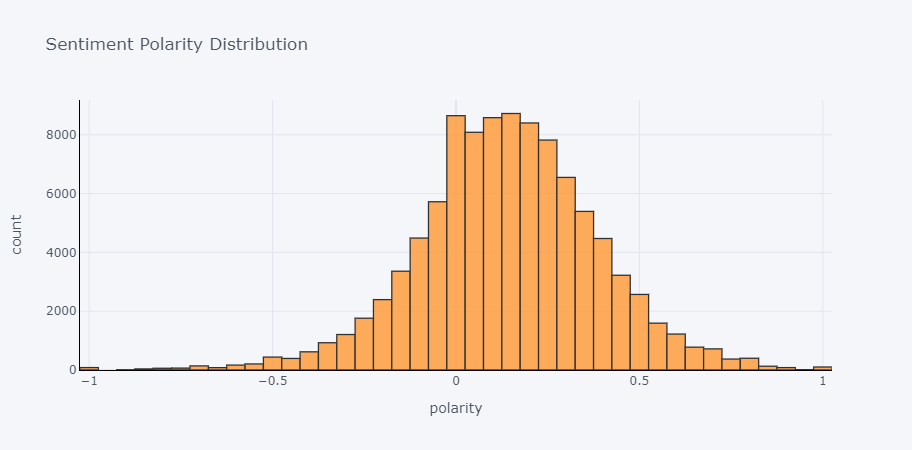

In [31]:
train_df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

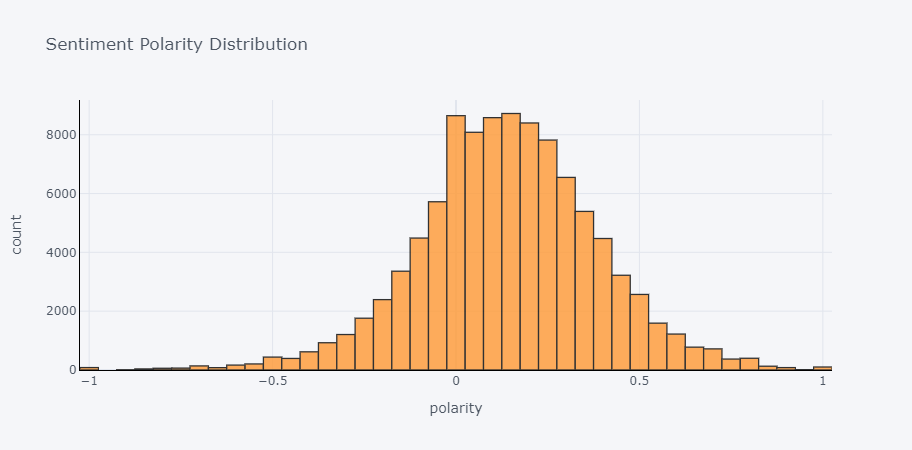

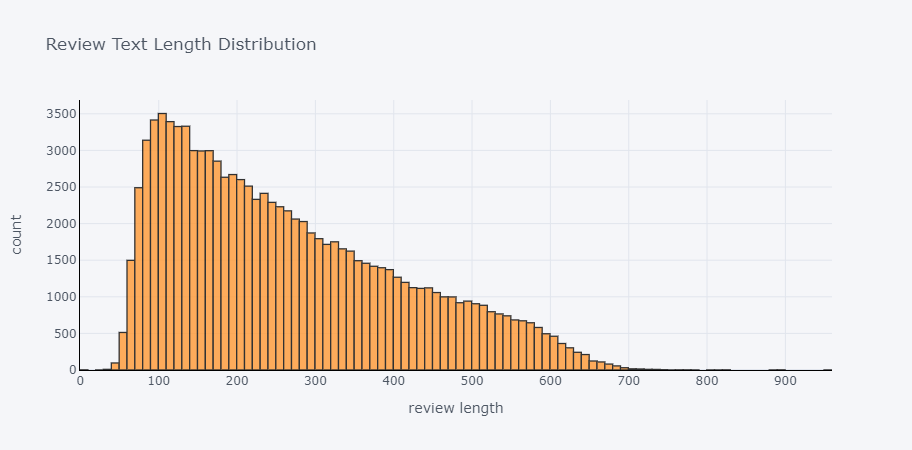

In [33]:
train_df['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

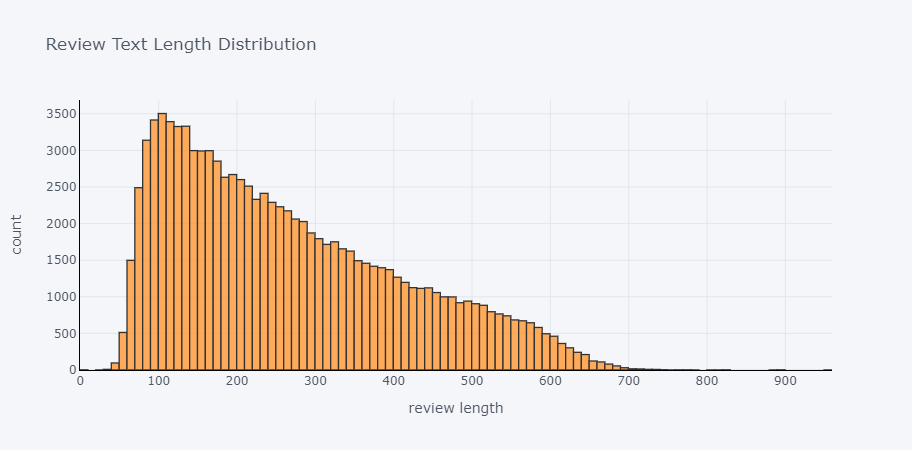

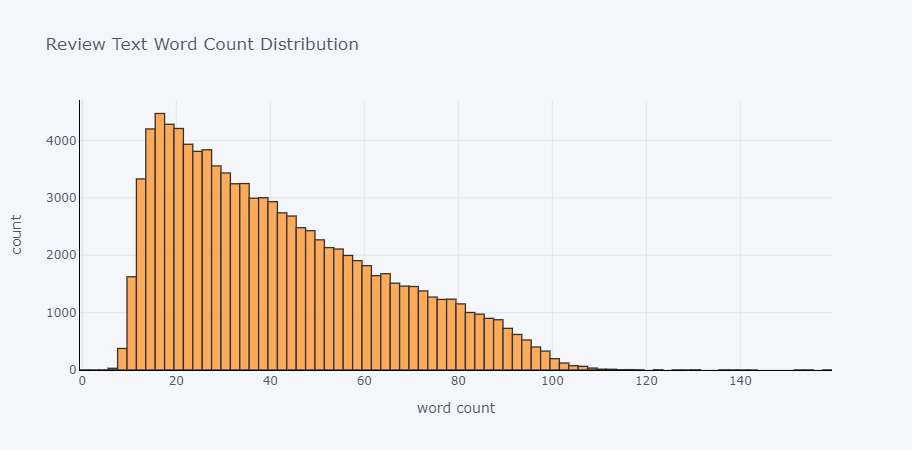

In [43]:
train_df['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

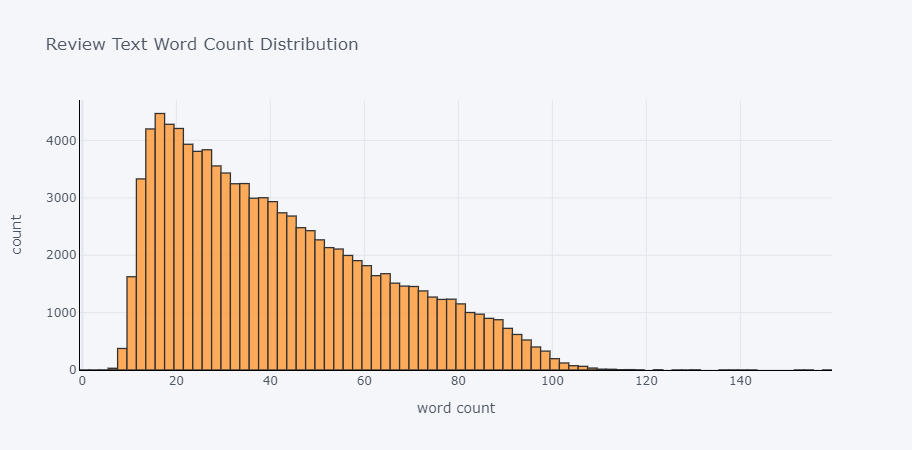

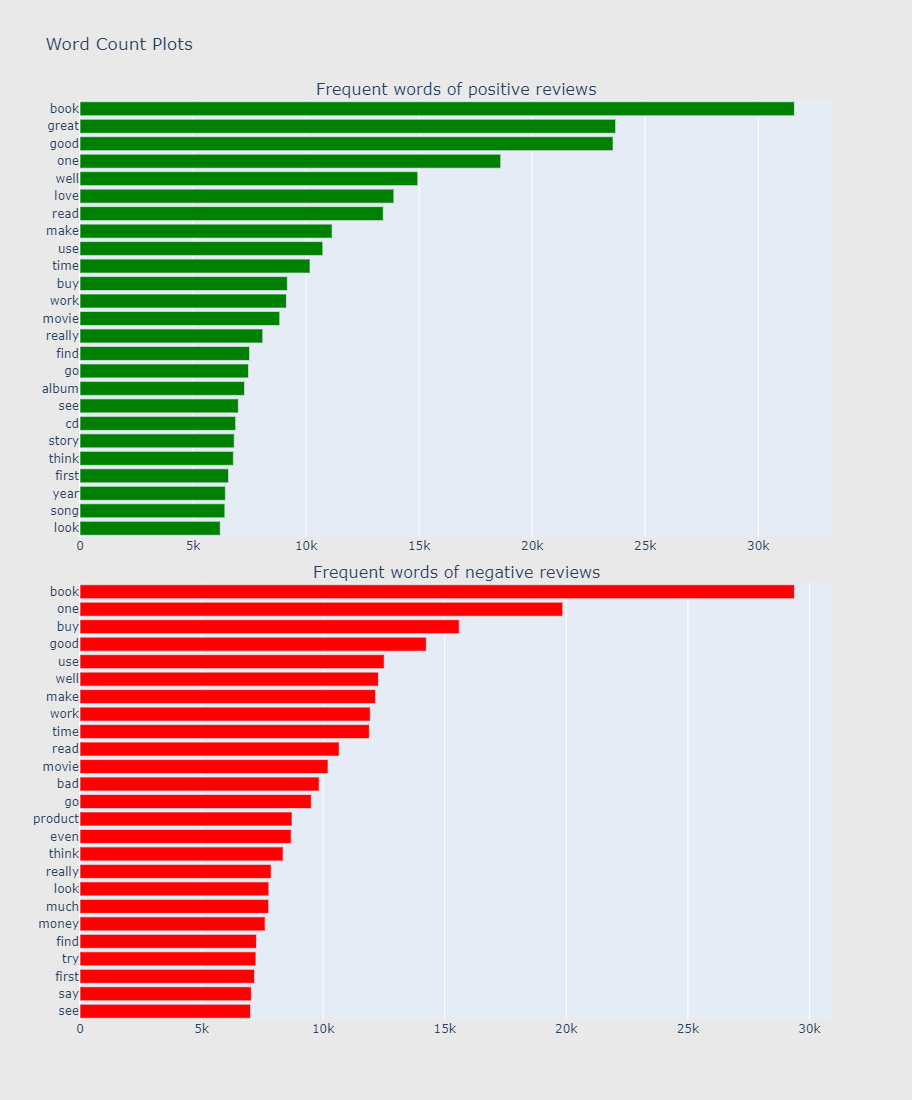

In [57]:
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
from plotly import tools

# Assuming 'train_df' contains the reviews and their corresponding sentiments
review_pos = train_df[train_df["sentiment"] == 'positive'].dropna()
review_neg = train_df[train_df["sentiment"] == 'negative'].dropna()

## Custom function for n-gram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## Custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.05,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig['layout'].update(height=1100, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')


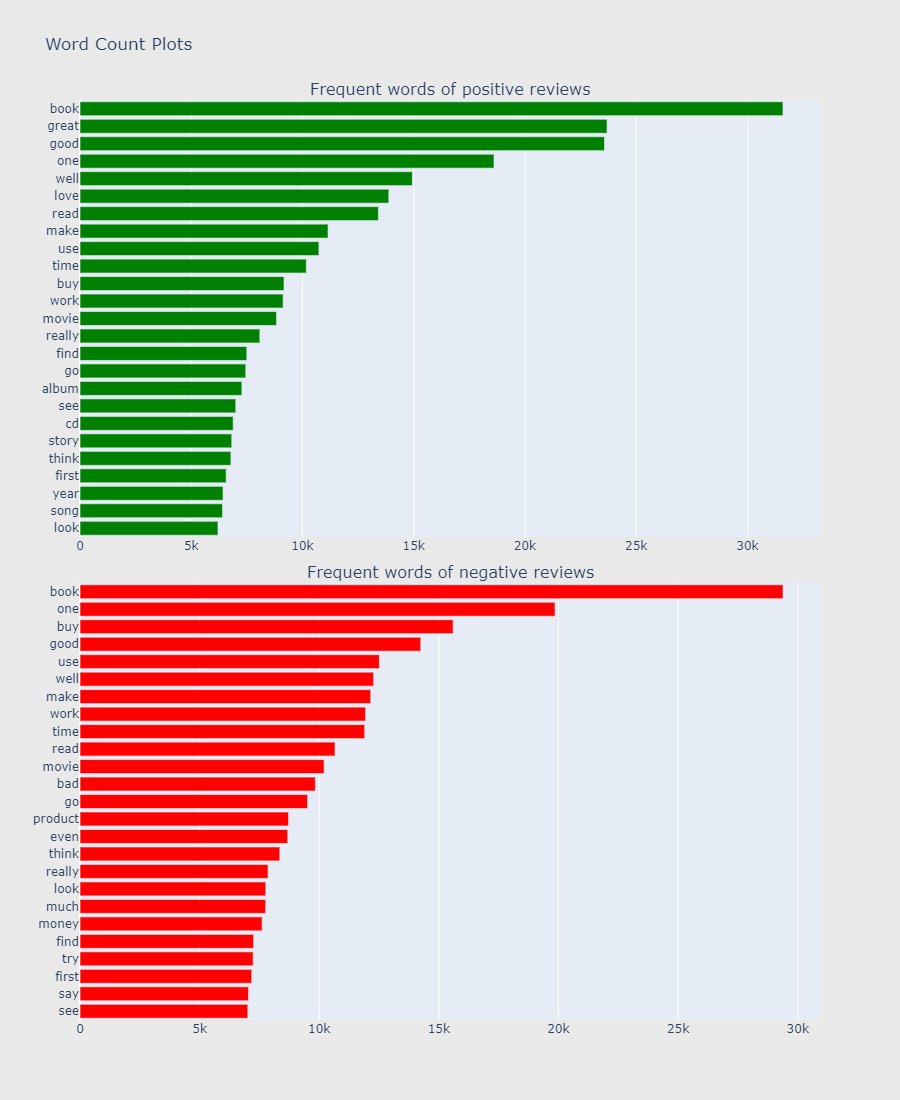

/opt/conda/lib/python3.10/site-packages/plotly/tools.py:455: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



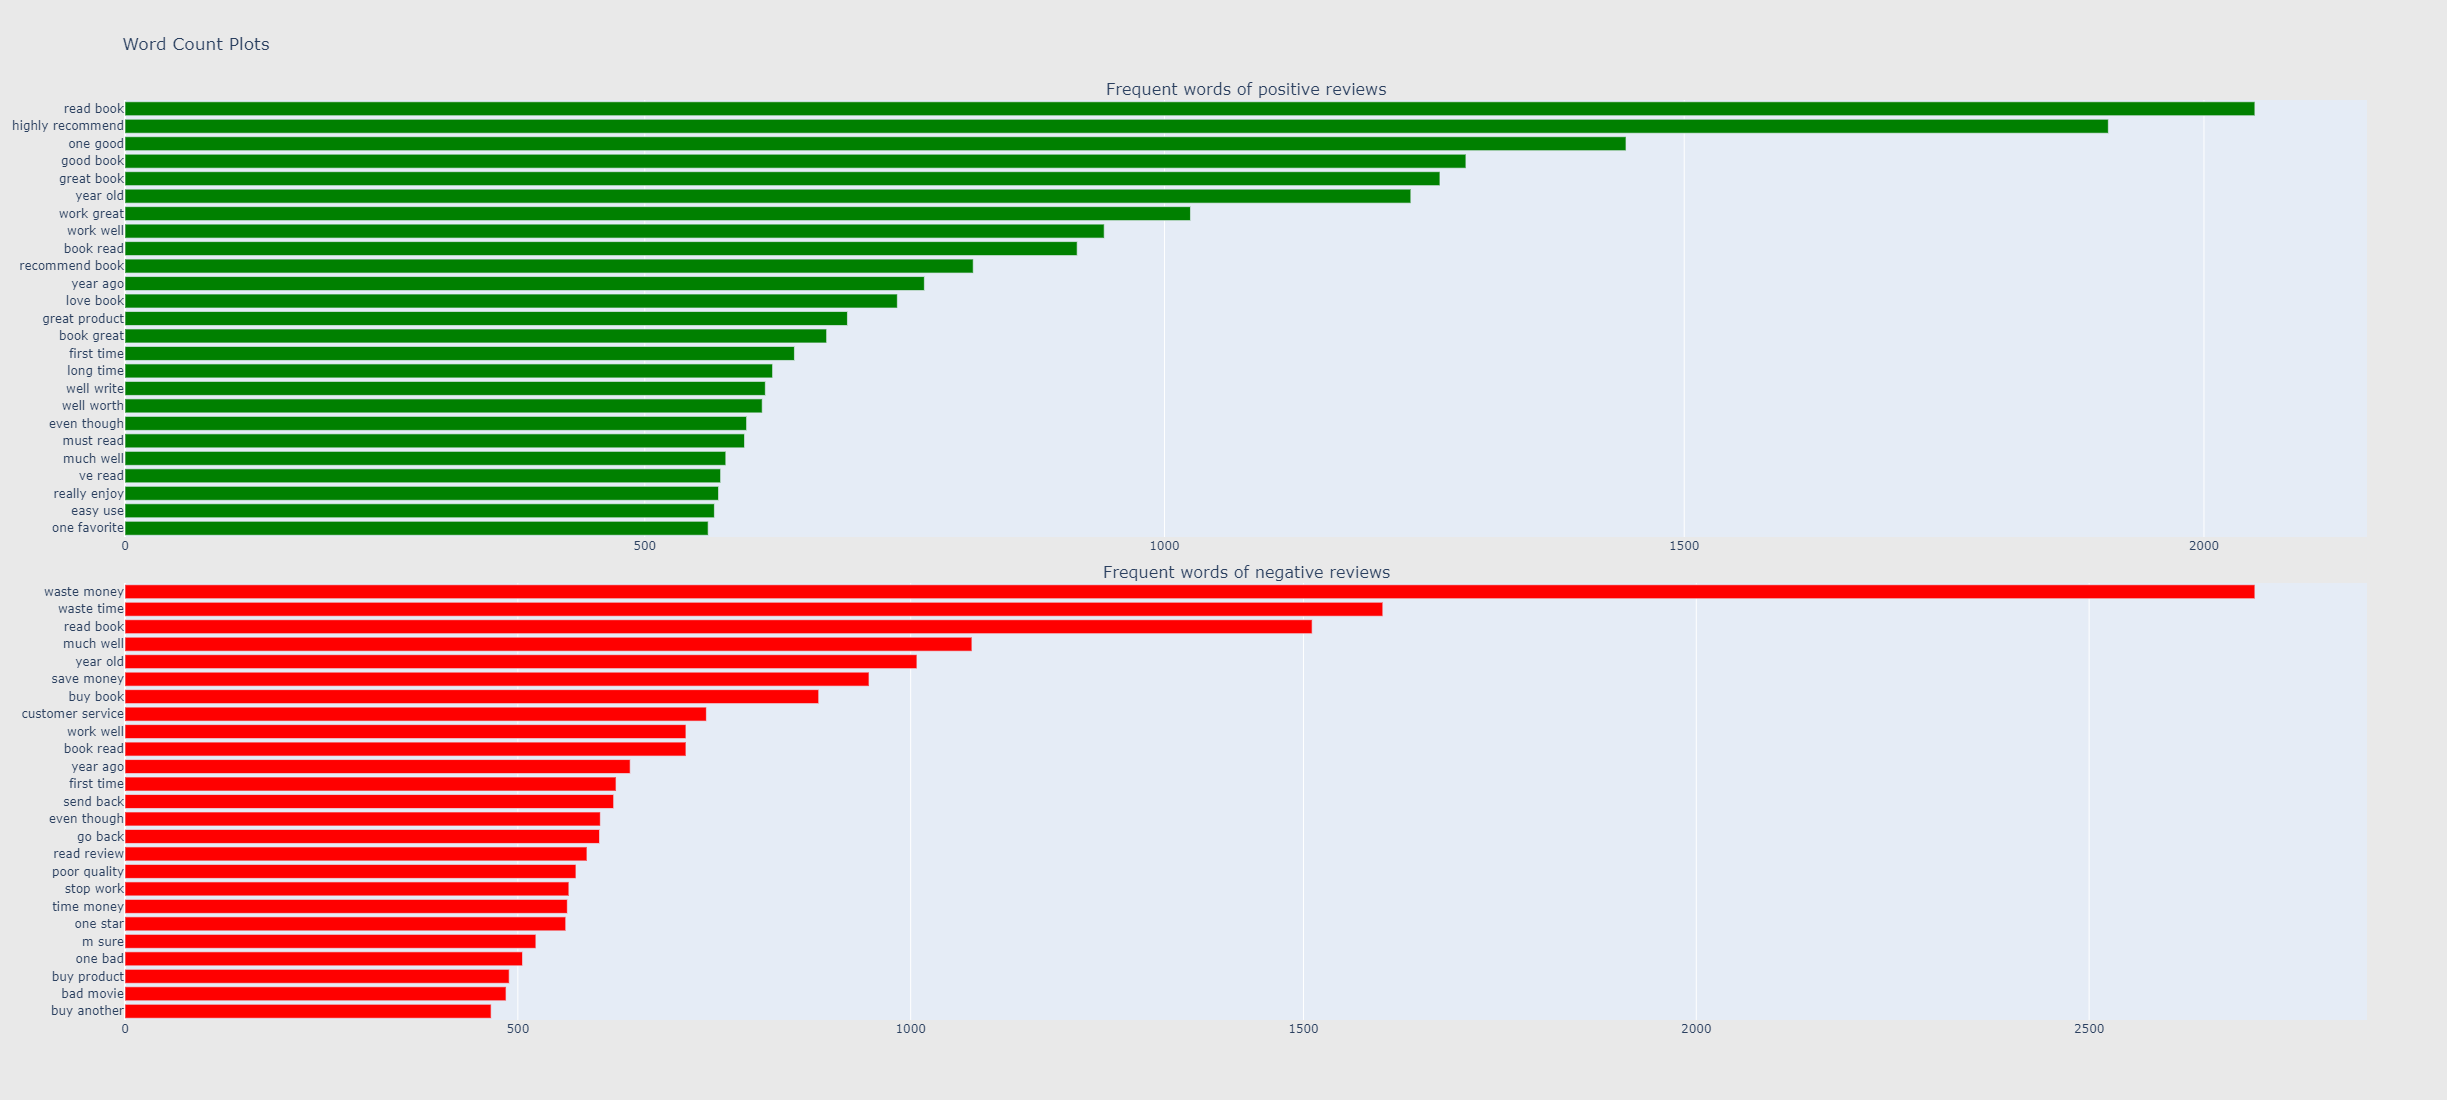

In [63]:
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
from plotly import tools

# Assuming 'train_df' contains the reviews and their corresponding sentiments
review_pos = train_df[train_df["sentiment"] == 'positive'].dropna()
review_neg = train_df[train_df["sentiment"] == 'negative'].dropna()

## Custom function for n-gram generation ##
def generate_ngrams(text, n_gram=2):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## Custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.05,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig['layout'].update(height=1100, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')


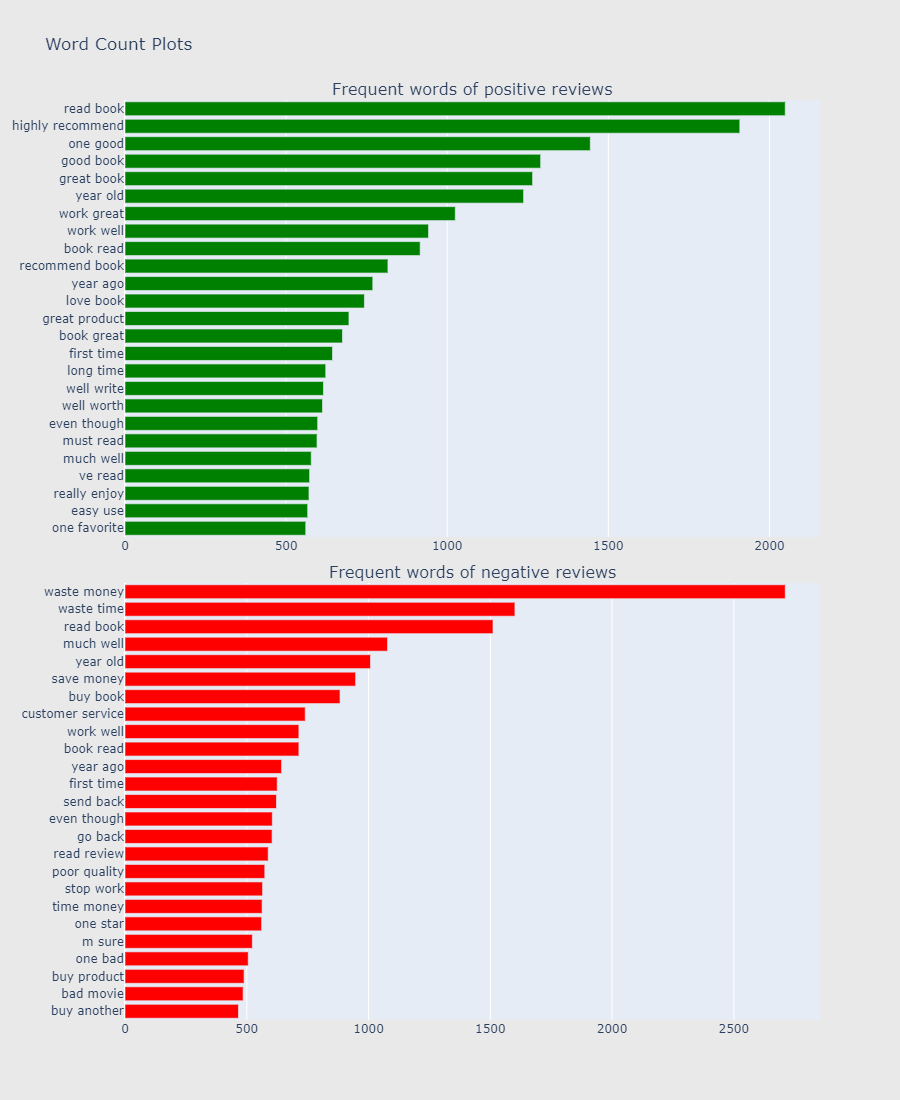

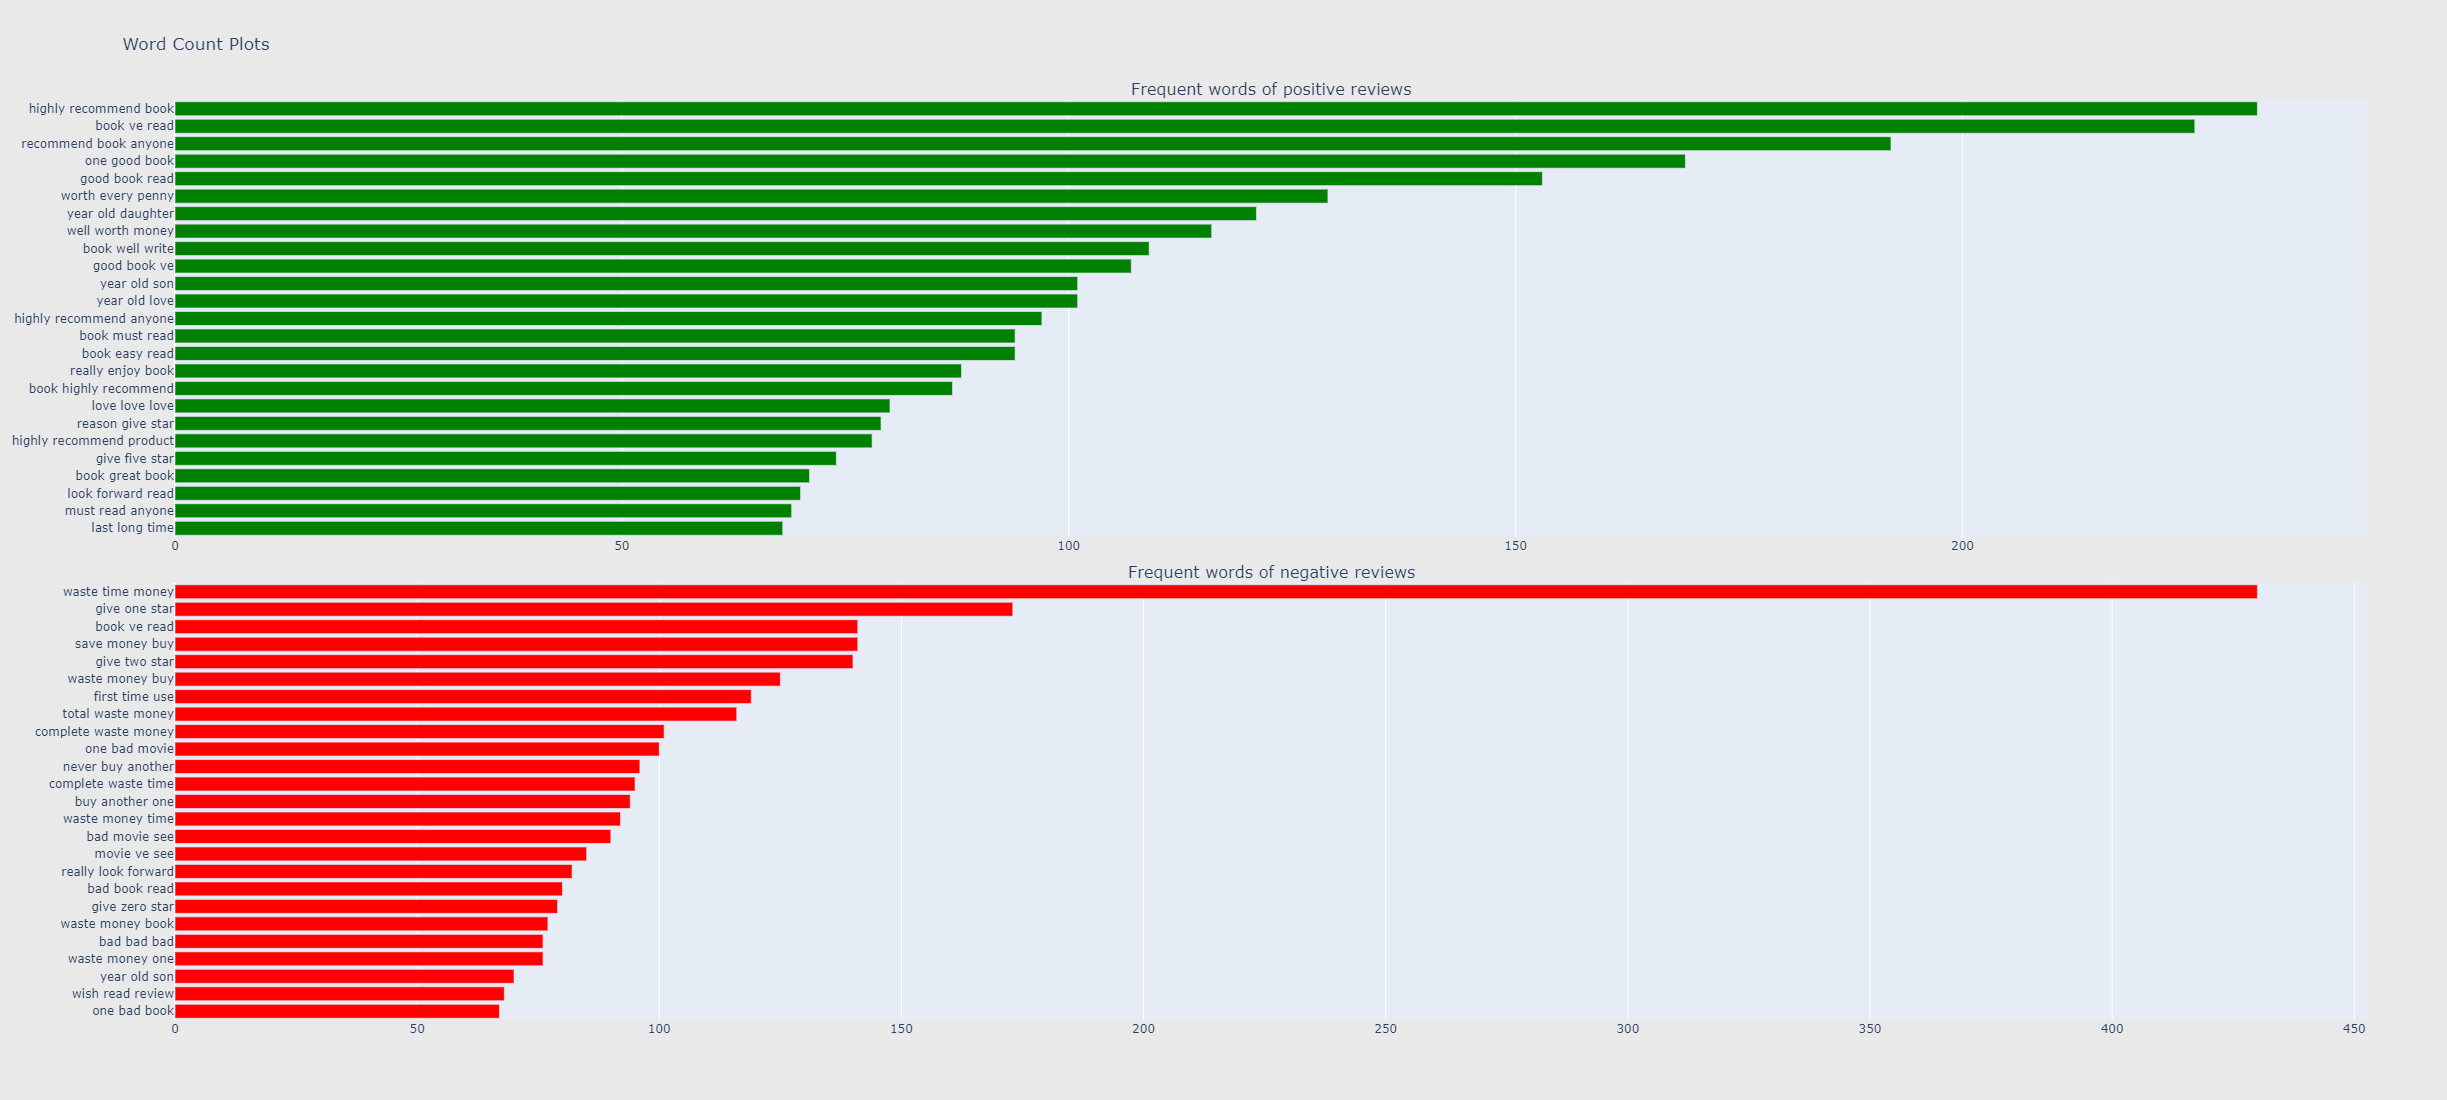

In [64]:
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import plotly.graph_objs as go
from plotly import tools

# Assuming 'train_df' contains the reviews and their corresponding sentiments
review_pos = train_df[train_df["sentiment"] == 'positive'].dropna()
review_neg = train_df[train_df["sentiment"] == 'negative'].dropna()

## Custom function for n-gram generation ##
def generate_ngrams(text, n_gram=3):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## Custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation='h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.05,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig['layout'].update(height=1100, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

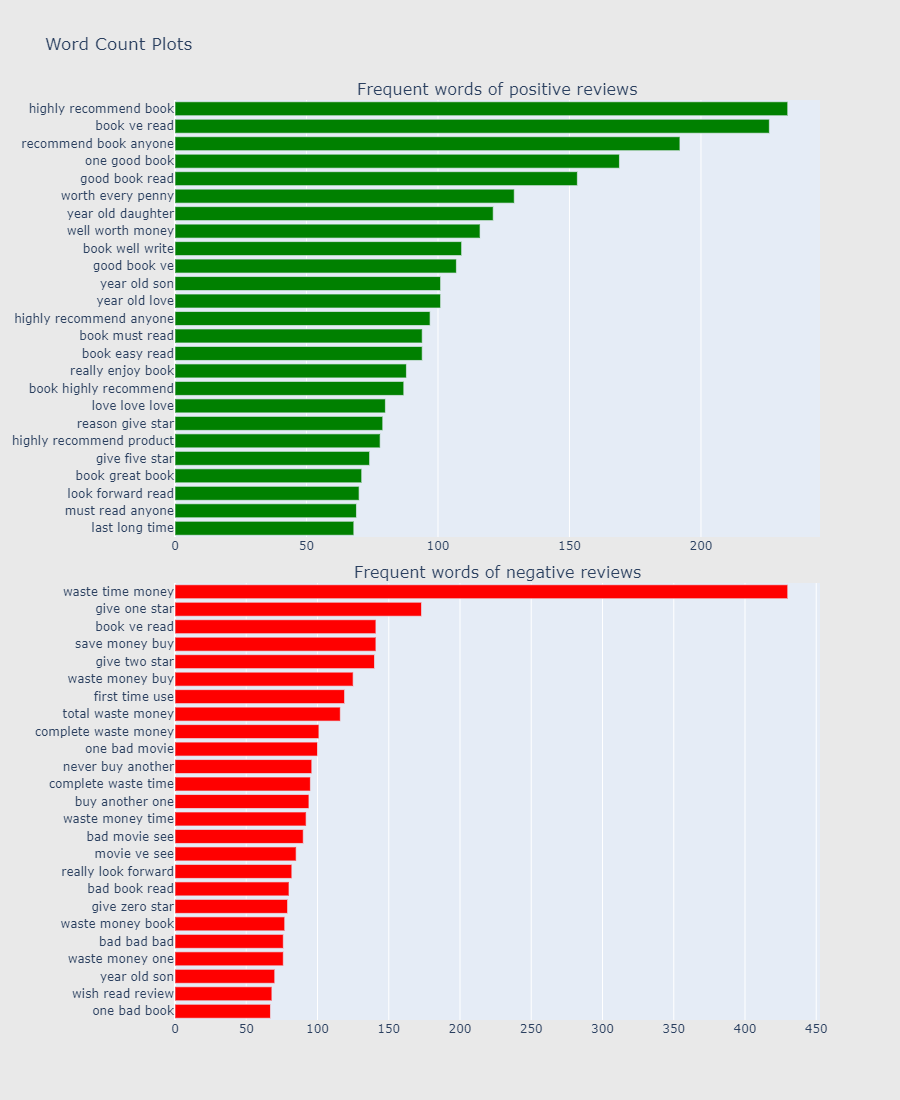

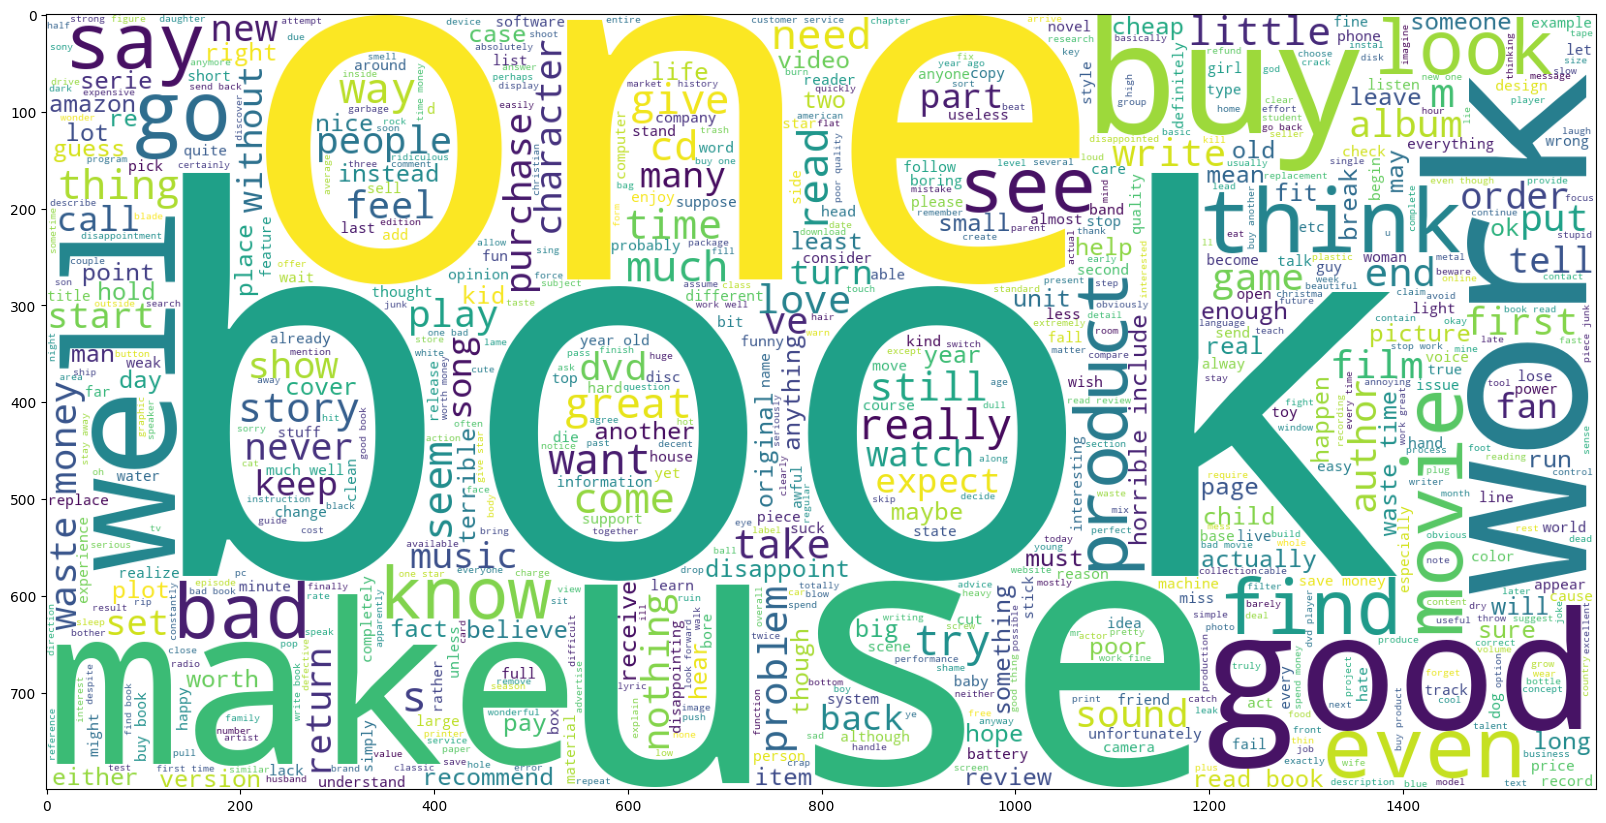

In [66]:
# Negative sentiment word cloud
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(train_df[train_df["sentiment"]=='negative'].reviews))
plt.imshow(wc1)

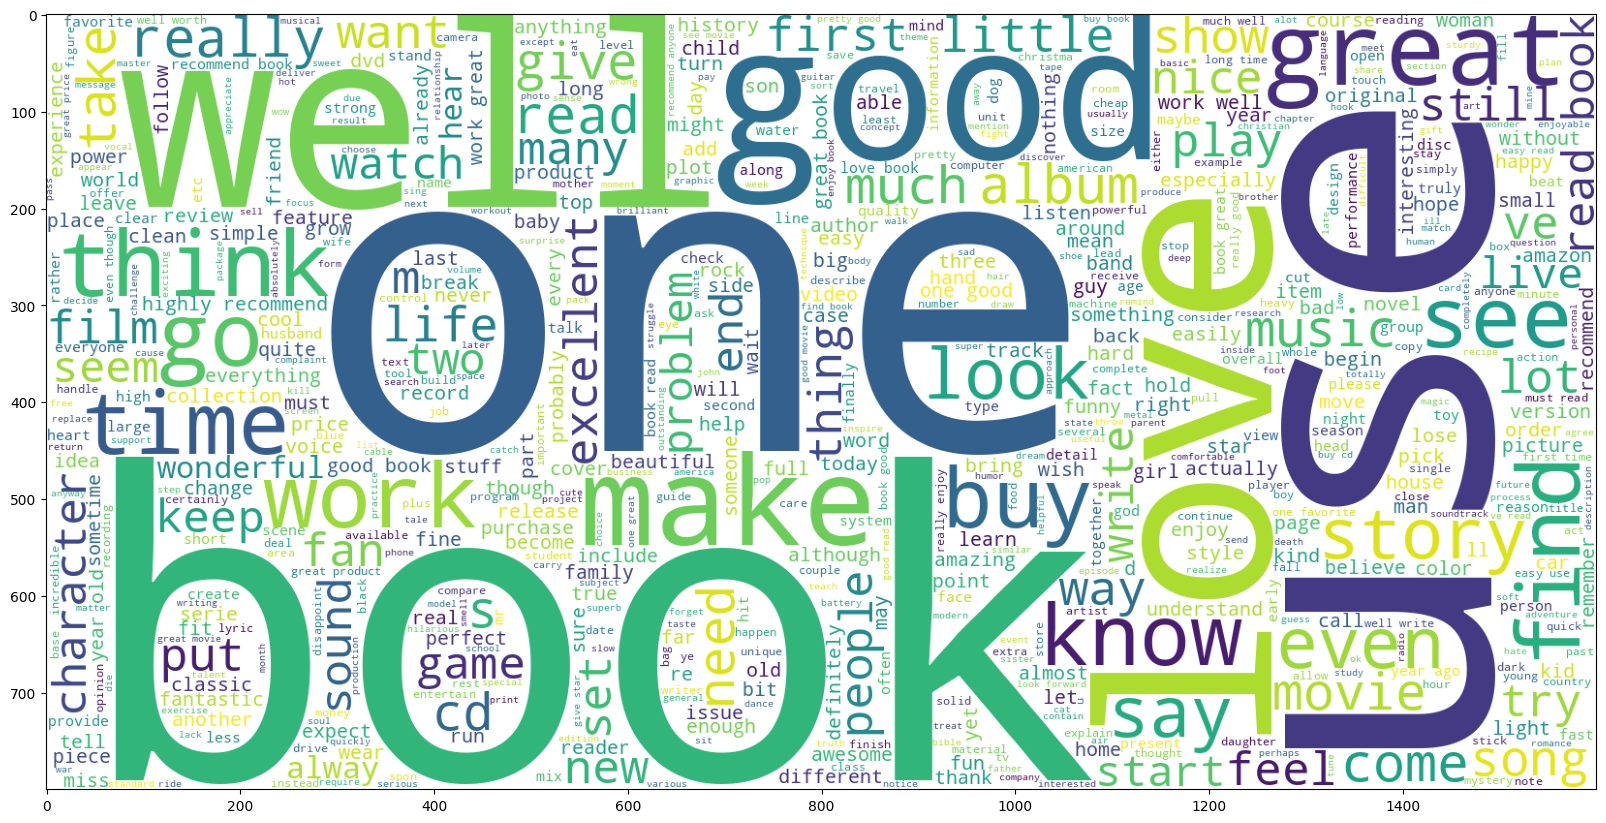

In [86]:
# Positive sentiment word cloud
from wordcloud import WordCloud
plt.figure(figsize=(20,20))
wc1 = WordCloud(max_words=2000,min_font_size=10, height=800, width=1600, 
               background_color="white").generate(" ".join(train_df[train_df["sentiment"]=='positive'].reviews))
plt.imshow(wc1)

# Predictions

In [60]:
X_train = train_df['reviews']
y_train = train_df['labels']

In [61]:
X_test = test_df['reviews']
y_test = test_df['labels']

In [62]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import roc_auc_score

In [63]:
# Converting text to bag of word vectors
count_vectorizer = CountVectorizer(max_features=10000,ngram_range=(1, 3))
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)
print(X_train_bow[0].todense())

[[0 0 0 ... 0 0 0]]


In [64]:
# Converting words to Tfidf vectors
tfidf_vectorizer = TfidfVectorizer(max_features=10000,ngram_range = (1,3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(X_train_tfidf[0].todense())

[[0. 0. 0. ... 0. 0. 0.]]


In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

**Training on Bag of words vectors**

In [75]:
from sklearn.metrics import classification_report
print('Logisitic Regression on bow vectors')
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_bow,y_train)
predict_lr = lr.predict(X_test_bow)
print(classification_report(y_test, predict_lr))
print("\n ROC AUC: ",roc_auc_score(y_test, predict_lr))

Logisitic Regression on bow vectors
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     19980
           1       0.89      0.90      0.90     20020

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000


 ROC AUC:  0.8962955962955963


In [68]:
print('Multinomial Naive Bayes on bow vectors')
nb = MultinomialNB()
nb.fit(X_train_bow,y_train)
predict_nb = nb.predict(X_test_bow)
print(classification_report(y_test, predict_nb))
print("\n ROC AUC: ",roc_auc_score(y_test, predict_nb))

Multinomial Naive Bayes on bow vectors
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     19980
           1       0.85      0.87      0.86     20020

    accuracy                           0.86     40000
   macro avg       0.86      0.86      0.86     40000
weighted avg       0.86      0.86      0.86     40000


 ROC AUC:  0.8607165857165857


In [71]:
print('Random Forest on bow vectors')
rf = RandomForestClassifier()
rf.fit(X_train_bow,y_train)
predict_rf = rf.predict(X_test_bow)
print(classification_report(y_test, predict_rf))
print("\n ROC AUC: ",roc_auc_score(y_test, predict_rf))

Random Forest on bow vectors
              precision    recall  f1-score   support

           0       0.85      0.88      0.87     19980
           1       0.88      0.85      0.86     20020

    accuracy                           0.86     40000
   macro avg       0.86      0.86      0.86     40000
weighted avg       0.86      0.86      0.86     40000


 ROC AUC:  0.8635426885426886


**Training on Tfidf vectors**

In [72]:
print('Logistic Regression on tfidf vectors')
lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(X_train_tfidf,y_train)
predict_lr = lr.predict(X_test_tfidf)
print(classification_report(y_test, predict_lr))
print("\n ROC AUC: ",roc_auc_score(y_test, predict_lr))

Logistic Regression on tfidf vectors
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     19980
           1       0.90      0.90      0.90     20020

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000


 ROC AUC:  0.9016727766727767


In [73]:
print('Multinomail Naive Bayes on tfidf vectors')
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)
predict_nb = nb.predict(X_test_tfidf)
print(classification_report(y_test, predict_nb))
print("\n ROC AUC: ",roc_auc_score(y_test, predict_nb))

Multinomail Naive Bayes on tfidf vectors
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     19980
           1       0.86      0.87      0.87     20020

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000


 ROC AUC:  0.8661473661473661


In [74]:
print('Random Forest on tfidf vectors')
rf = RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
predict_rf = rf.predict(X_test_tfidf)
print(classification_report(y_test, predict_rf))
print("\n ROC AUC: ",roc_auc_score(y_test, predict_rf))

Random Forest on tfidf vectors
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     19980
           1       0.87      0.85      0.86     20020

    accuracy                           0.86     40000
   macro avg       0.86      0.86      0.86     40000
weighted avg       0.86      0.86      0.86     40000


 ROC AUC:  0.863040038040038


**Training LSTM**

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_features = 10000  # Number of unique words to use

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

In [24]:
# using tokenizer to transform text messages into training and testing set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

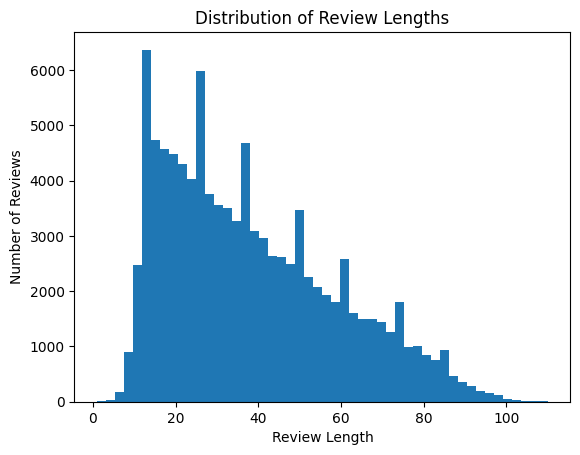

Max review length: 110
Mean review length: 38.323863238632384
Median review length: 34.0


In [25]:
import matplotlib.pyplot as plt

# Get the lengths of all reviews
review_lengths = [len(seq) for seq in X_train_seq]

# Plot the distribution of review lengths
plt.hist(review_lengths, bins=50)
plt.xlabel('Review Length')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Review Lengths')
plt.show()

# Print some statistics
print(f'Max review length: {max(review_lengths)}')
print(f'Mean review length: {np.mean(review_lengths)}')
print(f'Median review length: {np.median(review_lengths)}')

In [26]:
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=128)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=128)

In [27]:
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 6178, 3479,  129, 1445,  855,    4,  108,
         97,   33,  740,  182,  544,   12,  129,   22,   23,  197,    2,
         57,  283,  788,  897,  230,   15, 1386,   37,   46,   73,   31,
         22,  302,   73,   38, 4738,   47,   32, 3829,   91,    2,  785,
       5388,    7,   60,  545,  688,   81,  418,  230,  303,    2,   48,
          5,    1,  425,  688,  237,  248,  181,  365,   68,  776,  101,
        135,   32, 9080,   97,   12,  129, 1047,  963,    2,   49,  686,
         77,   27,    7,    6,  935, 1407, 3479], dtype=int32)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model

# Define and compile the model
model = Sequential()
model.add(Embedding(input_dim=max_features, output_dim=100))
model.add(Bidirectional(LSTM(100, return_sequences=True, dropout=0, recurrent_dropout=0)))  # Added return_sequences=True
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(32)))  # The second LSTM layer should receive the output of the first LSTM layer
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(128, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])


In [32]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor="val_loss",patience=2,verbose=True)

In [33]:
history = model.fit(X_train_seq_padded, y_train,batch_size=64,epochs=15,
                    validation_data=(X_test_seq_padded, y_test),callbacks=[early_stop])

Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - accuracy: 0.8237 - loss: 0.3758 - val_accuracy: 0.8957 - val_loss: 0.2557
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - accuracy: 0.9199 - loss: 0.2062 - val_accuracy: 0.9078 - val_loss: 0.2320
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9422 - loss: 0.1534 - val_accuracy: 0.8985 - val_loss: 0.2752
Epoch 4/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 27ms/step - accuracy: 0.9606 - loss: 0.1093 - val_accuracy: 0.9028 - val_loss: 0.2853
Epoch 4: early stopping


In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 128, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128, 200)       │       160,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 200)       │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        59,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,700,901 (14.12 MB)

 Trainable params: 1,233,457 (4.71 MB)

 Non-trainable params: 528 (2.06 KB)

 Optimizer params: 2,466,916 (9.41 MB)

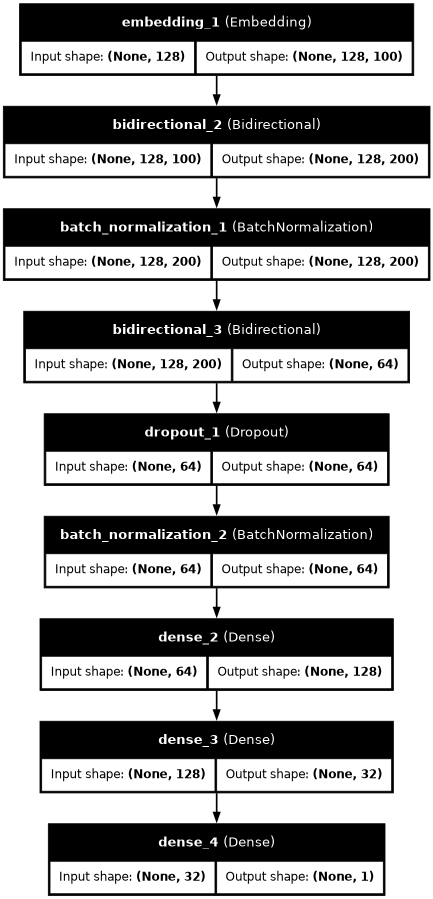

In [48]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, dpi=60)

In [34]:
model.evaluate(X_test_seq_padded, y_test)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9006 - loss: 0.2937


[0.2852802872657776, 0.90277498960495]

In [35]:
pred_test = model.predict(X_test_seq_padded)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step


In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test>0.5))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     19980
           1       0.90      0.90      0.90     20020

    accuracy                           0.90     40000
   macro avg       0.90      0.90      0.90     40000
weighted avg       0.90      0.90      0.90     40000



Text(58.222222222222214, 0.5, 'Truth')

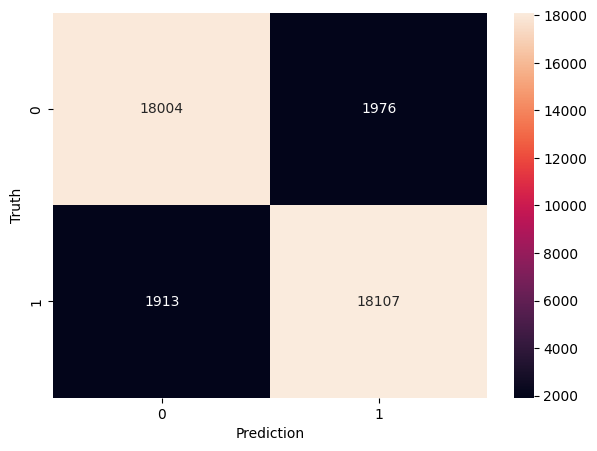

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_test>0.5)
plt.figure(figsize = (7,5))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

Text(0.5, 1.0, 'Training and Validation Accuracy')

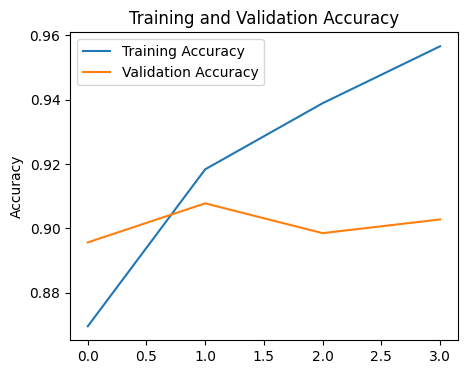

In [55]:
acc = history.history["accuracy"]
loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(5,4))
plt.plot(acc,label="Training Accuracy")
plt.plot(val_acc,label="Validation Accuracy")
plt.legend()
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")

Text(0.5, 1.0, 'Training and Validation Loss')

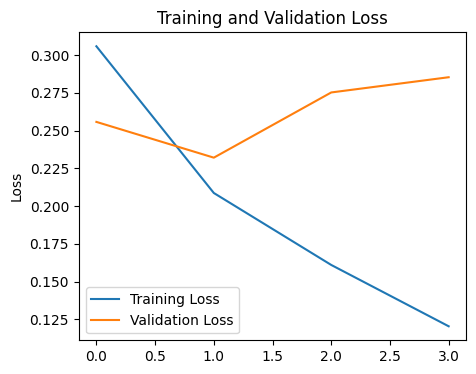

In [57]:
plt.figure(figsize=(5,4))
plt.plot(loss,label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend()
plt.ylabel("Loss")
plt.title("Training and Validation Loss")

In [59]:
print('LSTM Recurrent Neural Network: ' + str(roc_auc_score(y_test, pred_test>0.5)))

LSTM Recurrent Neural Network: 0.9027733277733276


**We can see that our LSTM model is the best performing model due to its highest ROC AUC score**